# Natural Language Processing for Shopping Reviews

In [34]:
# Pre-Processing
import string
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
import re
from nltk.stem import PorterStemmer

# Modeling
import statsmodels.api as sm
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment.util import *
from nltk.util import ngrams
from collections import Counter
from gensim.models import word2vec
from nltk.tokenize import word_tokenize
from gensim import corpora, models, similarities
from nltk.stem.lancaster import LancasterStemmer
from nltk.stem.porter import PorterStemmer
from pprint import pprint

#sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold

# For the first-time user, you should download these two pre-trained tokenizer
#nltk.download('punkt') 
#nltk.download('stopwords')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('Womens Clothing E-Commerce Reviews.csv',index_col = 0)
sentiment_label = df["Recommended IND"]
df.head()

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


In [3]:
# Pre-process
# choose review text
pdtextpreprocess = df[["Title","Review Text", "Rating"]]
pdtextpreprocess['index'] = pdtextpreprocess.index

documents = [str(m)+" "+str(n) for m,n in zip(pdtextpreprocess["Title"],pdtextpreprocess["Review Text"])] # add title as part of review text

In [4]:
texts_tokenized = [[word.lower() for word in word_tokenize(str(document))] for document in documents]#text tokenized and transformed to lowercase

stop_words = set(stopwords.words('english'))
texts_filtered_stopwords = [[word for word in document if not word in stop_words] for document in texts_tokenized]#move stop_words

# puncuations
english_punctuations = list(string.punctuation)
texts_filtered = [[word for word in document if not word in english_punctuations] for document in texts_filtered_stopwords]#move english_punctuations

stemmer = PorterStemmer()
#stemmer =LancasterStemmer()
texts_stemmed = [[stemmer.stem(word) for word in docment] for docment in texts_filtered]

all_stems = sum(texts_stemmed, [])
stems_once = set(stem for stem in set(all_stems) if all_stems.count(stem) == 1)

# stems_once.add('\'s') #remove 's in texts
texts = [[stem for stem in text if stem not in stems_once] for text in texts_stemmed]

In [5]:
from gensim.corpora import Dictionary

dictionary = Dictionary(texts)  # fit dictionary
corpus = [dictionary.doc2bow(line) for line in texts]  # convert corpus to BoW format

tfidf = models.TfidfModel(corpus) #calculate tf-idf
corpus_tfidf = tfidf[corpus] #use tf-idfs to represent documents

## I. LSA and LDA for Topic Modeling 

### Cross Validation is used for Number of Topics Determination 
  
"Topic coherence" is chosen as the metric to evaluate the LSA/LDA model. "U_mass" is applied for topic coherence evaluation for it is the fastest accordingly. The number of topics with the highest (closest to zero) U-mass coherense score will be applied.
  
The number of topics for the clothing-review dataset is intuitively estimated not to exceed 15 and to be at least 2, so a range of 2 to 16 with step of 1 is set as the parameter range to search.  
  
KFold with k=5 and shuffle is set as the cross validation approach.

### 1.1.1 LSA 

Like mentioned above, topic coherence (U_mass) is used for optimal number of topic selection.

In [6]:
kf = KFold(5,shuffle = True, random_state=233) #set seed
split = kf.split(corpus_tfidf)

topics_range = range(2,16,1)
coherence = pd.DataFrame()

for k in topics_range:
    cl = []
    for train_index, test_index in kf.split(corpus_tfidf):   
        X_train, X_test = np.array(corpus_tfidf)[train_index], np.array(corpus_tfidf)[test_index]        
        lsi = models.LsiModel(X_train,id2word= dictionary,num_topics= k)
        corpus_lsi = lsi[X_test]
        coherence_model = models.CoherenceModel(model=lsi,corpus=X_test, coherence='u_mass')
        cl.append(coherence_model.get_coherence())
    c=np.mean(cl)
    coherence=coherence.append(pd.Series([k,c]),ignore_index=True)

In [7]:
coherence.columns=['num_topics','topic_coherence']
print(coherence)

    num_topics  topic_coherence
0          2.0        -5.186406
1          3.0        -1.747202
2          4.0        -4.581156
3          5.0        -2.646875
4          6.0        -2.634702
5          7.0        -3.050800
6          8.0        -3.427609
7          9.0        -2.884550
8         10.0        -2.847903
9         11.0        -2.112357
10        12.0        -2.456222
11        13.0        -2.705581
12        14.0        -2.417725
13        15.0        -3.177091


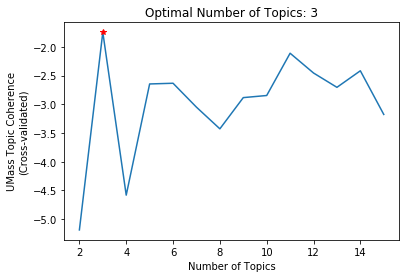

In [9]:
plt.plot(coherence.iloc[:,0],coherence.iloc[:,1])
plt.plot(coherence.iloc[1,0],coherence.iloc[1,1],'*r')
plt.xlabel('Number of Topics')
plt.ylabel('UMass Topic Coherence\n(Cross-validated)')
plt.title('Optimal Number of Topics: 3')
plt.show()

### 1.1.2 Apply the LSA Model with topic number = 3
In terms of the cross validation result, the number of topics is fine-tuned as 3.

In [17]:
num_topics= 3

lsi=models.LsiModel(corpus_tfidf,id2word=dictionary,num_topics=num_topics)
corpus_lsi = lsi[corpus_tfidf]

pprint(lsi.print_topics()) 

[(0,
  '0.929*"nan" + 0.080*"dress" + 0.063*"top" + 0.060*"love" + 0.057*"great" + '
  '0.055*"size" + 0.052*"fit" + 0.048*"look" + 0.047*"\'s" + 0.046*"color"'),
 (1,
  '-0.370*"nan" + 0.195*"dress" + 0.154*"top" + 0.139*"size" + 0.135*"love" + '
  '0.131*"great" + 0.128*"fit" + 0.119*"\'s" + 0.118*"look" + 0.113*"color"'),
 (2,
  '-0.304*"dress" + 0.264*"jean" + 0.257*"great" + 0.216*"shirt" + '
  '0.206*"sweater" + -0.189*"small" + 0.184*"comfort" + 0.179*"soft" + '
  '-0.152*"size" + 0.147*"pant"')]


In [36]:
# for doc in corpus_lsi:
#     print(doc)

In [25]:
coherence_model_lsi = models.CoherenceModel(model=lsi,corpus=corpus_tfidf, coherence='u_mass')
coherence_lsi = coherence_model_lsi.get_coherence()
print('\nCoherence Score of LSA with 3 Topics: ',coherence_lsi)


Coherence Score of LSA with 3 Topics:  -1.7437329622728857


### 1.2 LDA

Apart from topic coherence (u_mass), perplexity is applied for optimal number of topics selection.

### 1.2.1 topic coherence (u_mass)

In [8]:
kf = KFold(5,shuffle = True, random_state=233) #set seed
split = kf.split(corpus_tfidf)

topics_range = range(2,11,1)
lda_coherence = pd.DataFrame()

for k in topics_range:
    cl = []
    for train_index, test_index in kf.split(corpus_tfidf):   
        X_train, X_test = np.array(corpus_tfidf)[train_index], np.array(corpus_tfidf)[test_index]        
        lda = models.LdaModel(X_train,id2word= dictionary,num_topics= k)
        corpus_lda = lda[X_test]
        coherence_model = models.CoherenceModel(model=lda,corpus=X_test, coherence='u_mass')
        cl.append(coherence_model.get_coherence())
    c = np.mean(cl)
    lda_coherence = lda_coherence.append(pd.Series([k,c]),ignore_index=True)

In [9]:
lda_coherence.columns=['num_topics','topic_coherence']
print(lda_coherence)

   num_topics  topic_coherence
0         2.0        -1.626556
1         3.0        -1.945881
2         4.0        -2.327061
3         5.0        -4.169674
4         6.0        -3.680719
5         7.0        -5.863170
6         8.0        -6.384382
7         9.0        -6.005023
8        10.0        -7.188552


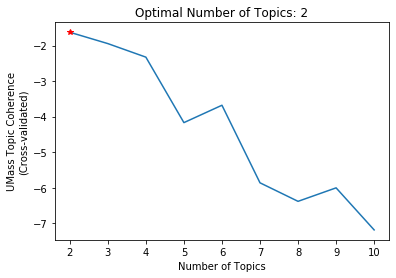

In [13]:
plt.plot(lda_coherence.iloc[:,0],lda_coherence.iloc[:,1])
plt.plot(lda_coherence.iloc[0,0],lda_coherence.iloc[0,1],'*r')
plt.xlabel('Number of Topics')
plt.ylabel('UMass Topic Coherence\n(Cross-validated)')
plt.title('Optimal Number of Topics: 2')
plt.show()

### 1.2.2 log_perpelexity method 

In [44]:
kf = KFold(5,shuffle = True, random_state=233) #set seed
split = kf.split(corpus_tfidf)

topics_range = range(2,16,1)
perplexity = pd.DataFrame()

for k in topics_range:
    pl = []
    for train_index, test_index in kf.split(corpus_tfidf):   
        X_train, X_test = np.array(corpus_tfidf)[train_index], np.array(corpus_tfidf)[test_index]        
        lda = models.LdaModel(X_train, id2word = dictionary, num_topics= k)
        pl.append(lda.log_perplexity(X_test))
    p = np.mean(pl)
    perplexity = perplexity.append(pd.Series([k,p]),ignore_index=True)

In [45]:
perplexity.columns=['num_topics','perplexity']
print(perplexity)

    num_topics  perplexity
0          2.0   -8.269255
1          3.0   -8.583579
2          4.0   -8.865361
3          5.0   -9.038513
4          6.0   -9.286377
5          7.0   -9.470919
6          8.0   -9.542532
7          9.0   -9.790395
8         10.0  -10.068865
9         11.0  -10.264723
10        12.0  -10.447620
11        13.0  -10.665433
12        14.0  -10.803584
13        15.0  -10.991494


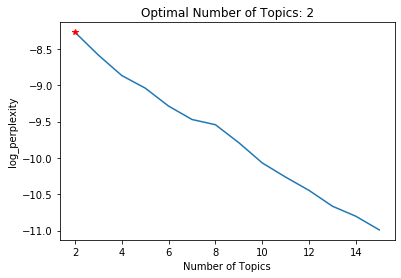

In [46]:
plt.plot(perplexity.iloc[:,0],perplexity.iloc[:,1])
plt.plot(perplexity.iloc[0,0],perplexity.iloc[0,1],'*r')
plt.xlabel('Number of Topics')
plt.ylabel('log_perplexity')
plt.title('Optimal Number of Topics: 2')
plt.show()

### 1.2.3 Apply the LDA Model with topic number = 2
In terms of the cross validation result, the number of topics is fine-tuned as 2.

In [26]:
num_topics = 2

lda = models.LdaModel(corpus_tfidf, id2word = dictionary, num_topics = num_topics)
corpus_lda = lda[corpus_tfidf]

print('The topics are: ')
pprint(lda.print_topics())

The topics are: 
[(0,
  '0.007*"dress" + 0.007*"top" + 0.005*"look" + 0.005*"size" + 0.005*"like" + '
  '0.005*"n\'t" + 0.005*"fit" + 0.005*"small" + 0.005*"fabric" + 0.005*"\'s"'),
 (1,
  '0.022*"nan" + 0.008*"love" + 0.008*"great" + 0.007*"dress" + '
  '0.006*"comfort" + 0.006*"jean" + 0.006*"color" + 0.005*"perfect" + '
  '0.005*"soft" + 0.005*"wear"')]


In [37]:
# print('The bag-of-topics features are:')
# for doc in corpus_lda:
#     print(doc)

In [28]:
coherence_model_lda = models.CoherenceModel(model=lda,corpus=corpus_tfidf, coherence='u_mass')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score of LDA with 2 topics: ',coherence_lda)


Coherence Score of LDA with 2 topics:  -1.7219031770321829


## II. Sentiment Prediction

(Recommended / Not recommended) of reviews using their bag-of-topics features by fitting a logistic regression model.

### 2.1.1 Prediction with LSA Model

We use the LSA (num-topics=3) model results as the output. Before going through the discrete choice model, we need to convert the bag of topics into a Dataframe for logistic regression.

In [20]:
num_topics = 3

columns = []
for i in range(num_topics):
    columns.append(i)

lsa_feature = pd.DataFrame(columns = columns)

for i in range(len(corpus_lsi)):
    l = pd.Series(x[1] for x in corpus_lsi[i])
    lsa_feature = lsa_feature.append(l,ignore_index = True)

In [21]:
#Train-Test Split
X_train,X_test,y_train,y_test = train_test_split(lsa_feature, sentiment_label, random_state = 233)

In [22]:
#fit to logistic regression model
LR = LogisticRegression()
LR.fit(X_train,y_train)
y_pred = LR.predict(X_test)

### 2.1.2 Calculate the prediction error
(Defined as the percentage of incorrect predictions)

In [23]:
print('Prediction Error with LSA model: {:.2%}'.format(1 - accuracy_score(y_pred, y_test)))

Prediction Error with LSA model: 17.88%


### 2.2.1 Prediction with LDA Model

In [29]:
num_topics = 2

columns = []
for i in range(num_topics):
    columns.append(i)

lda_feature = pd.DataFrame(columns = columns)

for i in range(len(corpus_lda)):
    l = pd.Series(x[1] for x in corpus_lda[i])
    lda_feature = lda_feature.append(l,ignore_index = True)

In [30]:
X_train,X_test,y_train,y_test = train_test_split(lda_feature, sentiment_label, random_state = 233)

In [31]:
LR = LogisticRegression()
LR.fit(X_train,y_train)
y_pred = LR.predict(X_test)

### 2.2.2 Calculate the prediction error
(Defined as the percentage of incorrect predictions)

In [32]:
print('Prediction Error with LDA model: {:.2%}'.format(1 - accuracy_score(y_pred, y_test)))

Prediction Error with LDA model: 17.81%
